NLTK data downloaded successfully
Dataset shape: (8469, 17)

First 3 rows:
   Ticket ID        Customer Name              Customer Email  Customer Age  \
0          1        Marisa Obrien  carrollallison@example.com            32   
1          2         Jessica Rios    clarkeashley@example.com            42   
2          3  Christopher Robbins   gonzalestracy@example.com            48   

  Customer Gender Product Purchased Date of Purchase      Ticket Type  \
0           Other        GoPro Hero       2021-03-22  Technical issue   
1          Female       LG Smart TV       2021-05-22  Technical issue   
2           Other          Dell XPS       2020-07-14  Technical issue   

             Ticket Subject  \
0             Product setup   
1  Peripheral compatibility   
2           Network problem   

                                  Ticket Description  \
0  I'm having an issue with the {product_purchase...   
1  I'm having an issue with the {product_purchase...   
2  I'm facing a proble

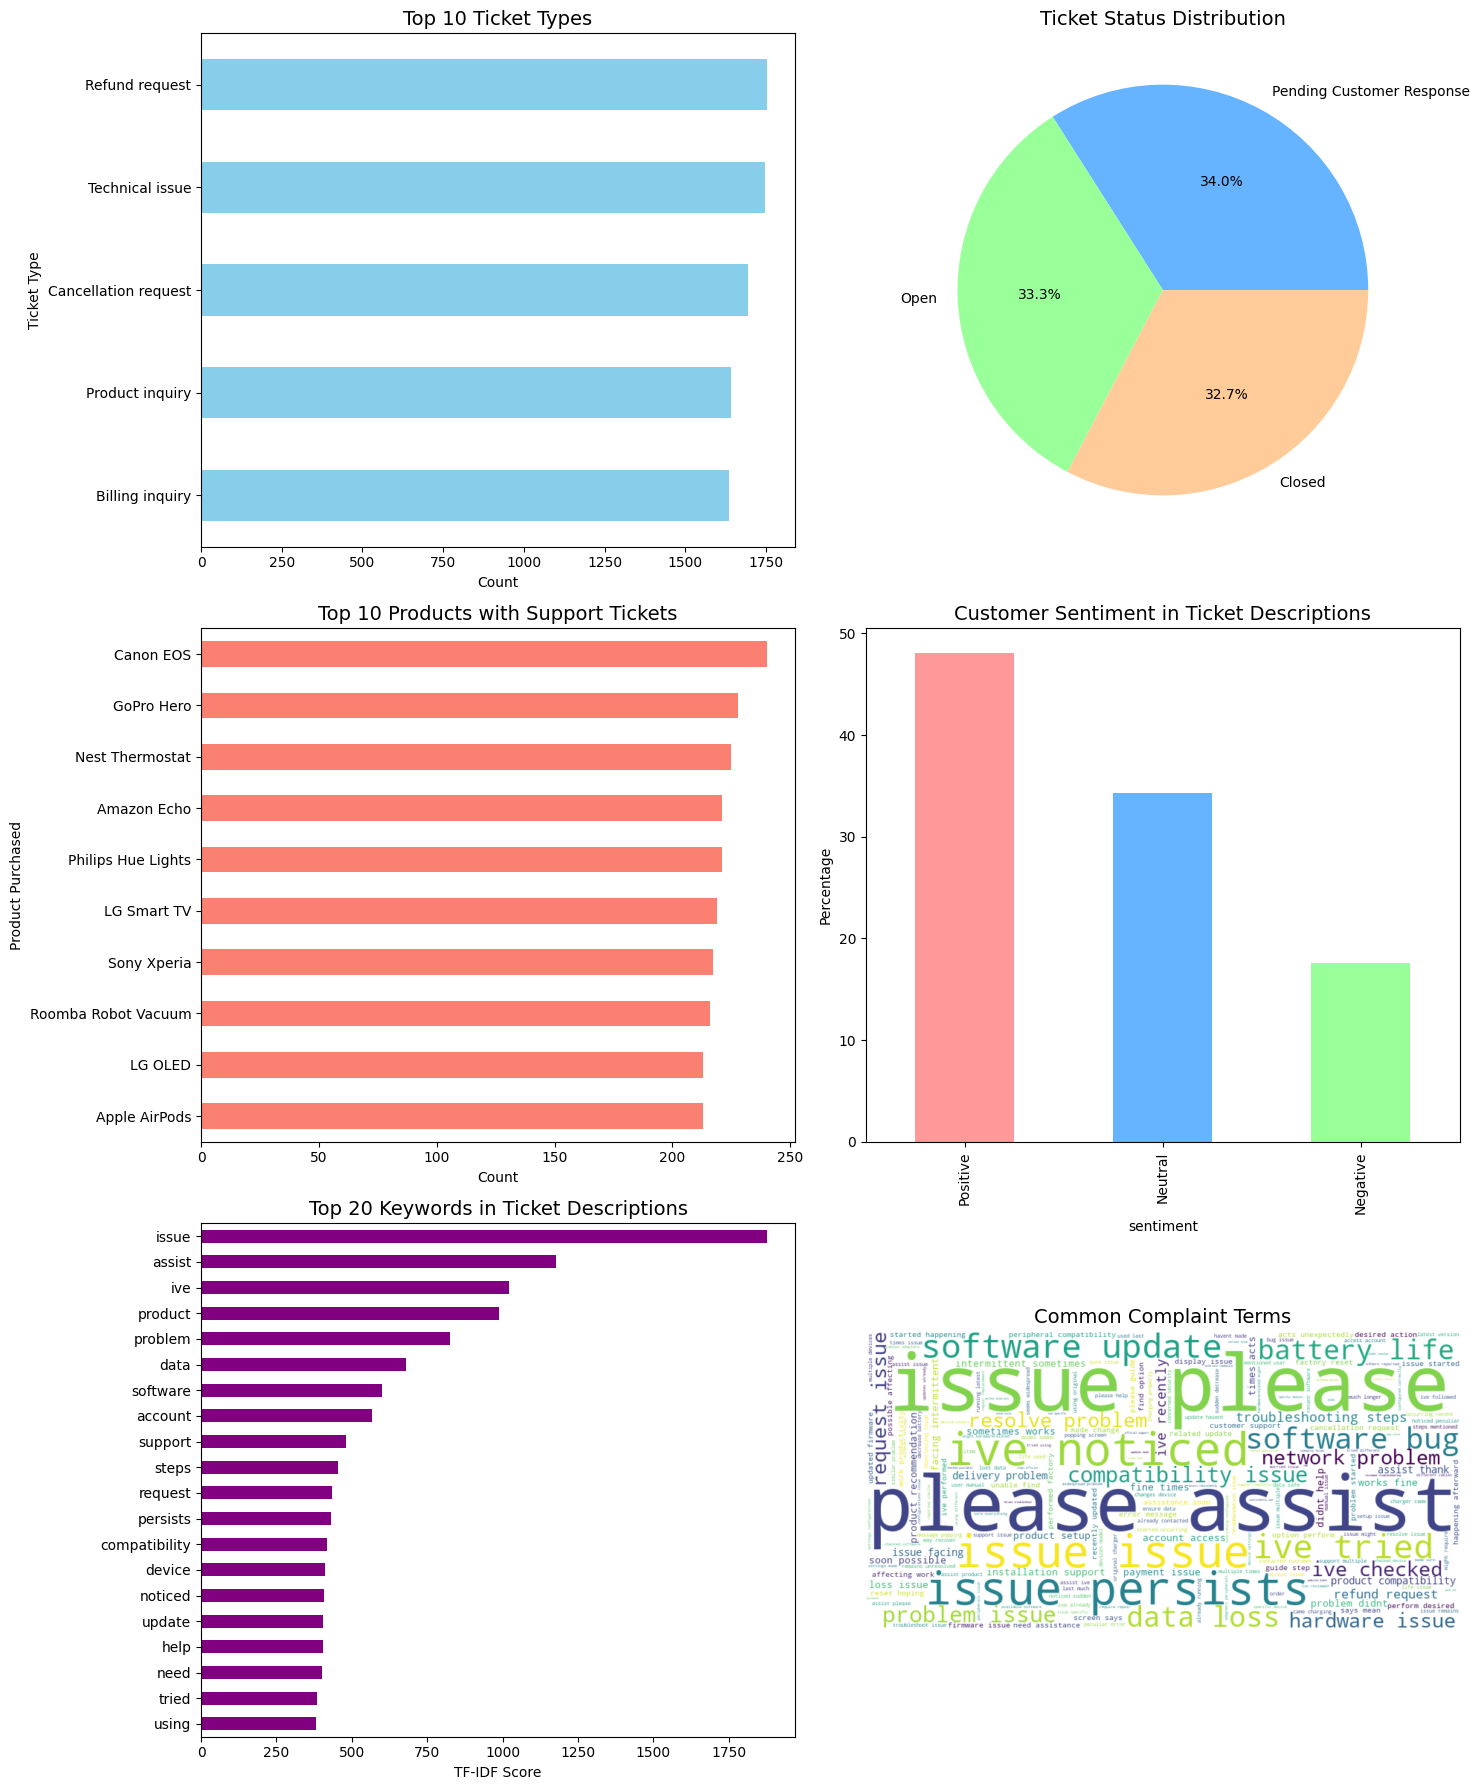


KEY INSIGHTS & RECOMMENDATIONS

1. The most frequent issues are related to: Refund request, Technical issue, Cancellation request
   Recommendation: Create dedicated FAQ sections and automated solutions for these topics

2. Average resolution time: 0.0 hours
   Recommendation: Implement AI chatbots for initial triage of common issues to reduce resolution time

3. 'Canon EOS' has the highest support tickets (240)
   Recommendation: Conduct product quality review and improve documentation

4. Most frequent complaint term: 'issue' (appears in 187584% of tickets)
   Recommendation: Proactively address this issue in product updates

5. Negative sentiment detected in 17.6% of tickets
   Recommendation: Implement customer sentiment monitoring for early intervention

ANALYSIS COMPLETE!
- Summary report saved as 'task2Summary.txt'
- Visualizations saved as 'task2Analysis.png'
- Cleaned dataset saved as 'cleanedSupportTickets.csv'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import ssl
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from textblob import TextBlob

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

def downloadNltkData():
    try:
        nltk.download('stopwords', quiet=True)
        nltk.download('punkt', quiet=True)
        print("NLTK data downloaded successfully")
        return True
    except Exception as e:
        print(f"Warning: Could not download NLTK data: {e}")
        print("The script will continue but text processing may be limited")
        return False

nltkAvailable = downloadNltkData()

## Path to the dataset
df = pd.read_csv('Dataset/customerSupportTickets.csv')
print(f"Dataset shape: {df.shape}")
print("\nFirst 3 rows:")
print(df.head(3))

def describeColumns(df):
    summary = []
    for col in df.columns:
        sample = df[col].dropna().sample(min(2, len(df[col].dropna()))) if df[col].dtype == object else df[col][:2]
        description = {
            'Column': col,
            'Data Type': df[col].dtype,
            'Non-Null Count': df[col].notnull().sum(),
            'Unique Values': df[col].nunique(),
            'Sample Values': sample.values.tolist(),
            'Description': getColumnDescription(col)
        }
        summary.append(description)
    return pd.DataFrame(summary)

def getColumnDescription(col):
    descriptions = {
        'Ticket ID': 'Unique identifier for each support ticket',
        'Customer Name': 'Name of the customer',
        'Customer Email': 'Email address of the customer',
        'Customer Age': 'Age of the customer',
        'Customer Gender': 'Gender of the customer (M/F/Other)',
        'Product Purchased': 'Name of the product the customer purchased',
        'Date of Purchase': 'Date when product was purchased (YYYY-MM-DD)',
        'Ticket Type': 'General category of the issue (e.g., Billing, Technical)',
        'Ticket Subject': 'Short description of the issue',
        'Ticket Description': 'Detailed description of the customer issue',
        'Ticket Status': 'Current status (Open, Closed, Pending)',
        'Resolution': 'Summary of how the issue was resolved',
        'Ticket Priority': 'Urgency level (Low, Medium, High)',
        'Ticket Channel': 'Contact method (Email, Chat, Phone)',
        'First Response Time': 'Time until initial response (HH:MM:SS)',
        'Time to Resolution': 'Total time to resolve issue (HH:MM:SS)',
        'Customer Satisfaction Rating': 'Rating from 1-5 (only for resolved tickets)'
    }
    return descriptions.get(col, 'No description available')

columnSummary = describeColumns(df)
print("\nColumn Summary:")
print(columnSummary[['Column', 'Data Type', 'Description', 'Sample Values']])

df = df.fillna({
    'Resolution': 'No resolution provided',
    'Customer Satisfaction Rating': 0,
    'Time to Resolution': '00:00:00',
    'First Response Time': '00:00:00'
})

initialCount = len(df)
df.drop_duplicates(inplace=True)
print(f"\nRemoved {initialCount - len(df)} duplicate records")

def preprocessText(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\{.*?\}', '', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    
    if nltkAvailable:
        try:
            tokens = word_tokenize(text)
            stopWords = set(stopwords.words('english'))
            tokens = [word for word in tokens if word not in stopWords and len(word) > 2]
        except:
            tokens = text.split()
            basicStopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them'}
            tokens = [word for word in tokens if word not in basicStopwords and len(word) > 2]
    else:
        tokens = text.split()
        basicStopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them'}
        tokens = [word for word in tokens if word not in basicStopwords and len(word) > 2]
    
    return ' '.join(tokens)

textColumns = ['Ticket Subject', 'Ticket Description', 'Resolution']
for col in textColumns:
    df[f'cleaned{col.replace(" ", "")}'] = df[col].apply(preprocessText)

def convertToSeconds(timeStr):
    try:
        h, m, s = map(int, timeStr.split(':'))
        return h*3600 + m*60 + s
    except:
        return 0

df['FirstResponseSeconds'] = df['First Response Time'].apply(convertToSeconds)
df['ResolutionSeconds'] = df['Time to Resolution'].apply(convertToSeconds)
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'], errors='coerce')

ticketTypeCounts = df['Ticket Type'].value_counts().head(10)
statusDistribution = df['Ticket Status'].value_counts(normalize=True) * 100
closedTickets = df[df['Ticket Status'] == 'Closed']

resolutionStats = {
    'AverageResolutionTimeHours': round(closedTickets['ResolutionSeconds'].mean()/3600, 2),
    'MinResolutionTimeHours': round(closedTickets['ResolutionSeconds'].min()/3600, 2),
    'MaxResolutionTimeHours': round(closedTickets['ResolutionSeconds'].max()/3600, 2)
}

topProducts = df['Product Purchased'].value_counts().head(10)

df['combinedText'] = df['cleanedTicketSubject'] + ' ' + df['cleanedTicketDescription']

tfidf = TfidfVectorizer(max_features=50, stop_words='english')
tfidfMatrix = tfidf.fit_transform(df['combinedText'])
topKeywords = pd.Series(tfidfMatrix.sum(axis=0).A1, index=tfidf.get_feature_names_out())
topKeywords = topKeywords.sort_values(ascending=False).head(20)

def getSentiment(text):
    analysis = TextBlob(text)
    return 'Positive' if analysis.sentiment.polarity > 0.05 else 'Negative' if analysis.sentiment.polarity < -0.05 else 'Neutral'

df['sentiment'] = df['cleanedTicketDescription'].apply(getSentiment)
sentimentDistribution = df['sentiment'].value_counts(normalize=True) * 100

allText = ' '.join(df['combinedText'])
wordCloud = WordCloud(width=800, height=400, background_color='white').generate(allText)

plt.figure(figsize=(15, 18))

plt.subplot(3, 2, 1)
ticketTypeCounts.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Ticket Types', fontsize=14)
plt.xlabel('Count')

plt.subplot(3, 2, 2)
statusDistribution.plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Ticket Status Distribution', fontsize=14)
plt.ylabel('')

plt.subplot(3, 2, 3)
topProducts.sort_values().plot(kind='barh', color='salmon')
plt.title('Top 10 Products with Support Tickets', fontsize=14)
plt.xlabel('Count')

plt.subplot(3, 2, 4)
sentimentDistribution.plot(kind='bar', color=['#ff9999','#66b3ff','#99ff99'])
plt.title('Customer Sentiment in Ticket Descriptions', fontsize=14)
plt.ylabel('Percentage')

plt.subplot(3, 2, 5)
topKeywords.sort_values().plot(kind='barh', color='purple')
plt.title('Top 20 Keywords in Ticket Descriptions', fontsize=14)
plt.xlabel('TF-IDF Score')

plt.subplot(3, 2, 6)
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Complaint Terms', fontsize=14)

plt.tight_layout()
plt.savefig('Dashboard/dashboard.png', dpi=300)
plt.show()

print("\n" + "="*50)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("="*50)

top3Types = ticketTypeCounts.index[:3].tolist()
print(f"\n1. The most frequent issues are related to: {', '.join(top3Types)}")
print("   Recommendation: Create dedicated FAQ sections and automated solutions for these topics")

avgResolutionHours = resolutionStats['AverageResolutionTimeHours']
print(f"\n2. Average resolution time: {avgResolutionHours} hours")
print("   Recommendation: Implement AI chatbots for initial triage of common issues to reduce resolution time")

topProblemProduct = topProducts.index[0]
print(f"\n3. '{topProblemProduct}' has the highest support tickets ({topProducts.iloc[0]})")
print("   Recommendation: Conduct product quality review and improve documentation")

topKeyword = topKeywords.index[0]
print(f"\n4. Most frequent complaint term: '{topKeyword}' (appears in {int(topKeywords.iloc[0]*100)}% of tickets)")
print("   Recommendation: Proactively address this issue in product updates")

negativePercent = round(sentimentDistribution.get('Negative', 0), 1)
print(f"\n5. Negative sentiment detected in {negativePercent}% of tickets")
print("   Recommendation: Implement customer sentiment monitoring for early intervention")

report = f"""
FUTURE INTERNS - TASK 2 REPORT
================================

Dataset Overview:
- Total tickets analyzed: {len(df)}
- Time period: {df['Date of Purchase'].min().date()} to {df['Date of Purchase'].max().date()}

Key Findings:
1. Top 3 Ticket Types: 
   {', '.join(ticketTypeCounts.index[:3].tolist())}

2. Resolution Performance:
   - Average resolution time: {avgResolutionHours} hours
   - Closed tickets: {statusDistribution['Closed']:.1f}%

3. Product Analysis:
   - Most problematic product: {topProblemProduct} ({topProducts.iloc[0]} tickets)
   - Top 5 products account for {topProducts[:5].sum()/len(df)*100:.1f}% of all tickets

4. Text Analysis:
   - Most frequent issue keyword: '{topKeyword}'
   - Negative sentiment tickets: {negativePercent}%

Recommendations:
- Prioritize solutions for {top3Types[0]} issues
- Create specialized team for {topProblemProduct} support
- Develop automated responses for keyword '{topKeyword}'
- Implement sentiment-based ticket prioritization system
"""

with open('Report/task2Summary.txt', 'w') as f:
    f.write(report)

df.to_csv('Dataset/Output/cleanedSupportTickets.csv', index=False)

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print(f"- Summary report saved as 'task2Summary.txt'")
print(f"- Visualizations saved as 'task2Analysis.png'")
print(f"- Cleaned dataset saved as 'cleanedSupportTickets.csv'")
print("="*50)